# (30) HRF -- Cosine sim

**Motivation**: Quantify HRF results using cosine similarity, save pvals. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


muted = sns.color_palette('muted', n_colors=10)
colors = [muted[0], muted[9], muted[1], muted[8]]


def _fix(k: str):
    k = k.replace('preproc\n', '')
    if 'hrf' in k:
        k = k.split('\n')[-1]
        k = f"{k} (HRF)"
    return k


def _do(pi, pi_indiv, n_resamples: int = int(1e4)):
    sim, sim_overall = cosine_sim(pi_indiv)
    sim_b, sim_overall_b = cosine_sim_boot(
        pi, n_resamples=n_resamples)
    test = sim_perm(pi, n_resamples=n_resamples * 10)
    test = {
        k: d for k, d
        in test.items()
        if isinstance(d, dict)
    }

    # put results as dict
    test_fixed = {}
    for k, d in test.items():
        d_fixed = {}
        for a, b in d.items():
            if isinstance(b, np.ndarray):
                k1, k2 = a
                d_fixed[(_fix(k1), _fix(k2))] = b
            else:
                (k1, k2), (k3, k4) = a
                d_fixed[(
                    (_fix(k1), _fix(k2)),
                    (_fix(k3), _fix(k4)),
                )] = b
        test_fixed[k] = d_fixed
    test = test_fixed
    
    results = {
        'sim': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim.items()},
        'sim_b': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim_b.items()},
    }
    results_overall = {7: {
        'sim_overall': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim_overall.items()},
        'sim_overall_b': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim_overall_b.items()},
    }}
    return results, results_overall, test


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Mice

In [3]:
mice, props = default_props_anesth()
kws_show = show_kws(props['num_k'])
bs = Base(mice, mode='ca2')

translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}
kws_fig = dict(bbox_inches='tight', dpi=300, transparent=True)
fig_dir = pjoin(fig_base_dir, 'rebuttal', 'hrf_cos')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal/hrf_cos

## HRF (load)

In [4]:
pi = np.load(
    pjoin(tmp_dir, 'pi_run.npy'),
    allow_pickle=True,
).item()

# fix ordering (bring BOLD to front)
order = list(pi)
item = next(e for e in order if 'BOLD' in e)
order.pop(order.index(item))
order = [item] + order
pi = {k: pi.get(k) for k in order}

# compute individual & group results
pi_indiv = {
    k: avg(v, ndim_start=1)
    for k, v in pi.items()
}
pi_grp = {
    k: avg(v) for k, v
    in pi_indiv.items()
}

## Cos. Sim. Boot

In [5]:
%%time

n_resamples = int(1e4)

results, results_overall, test = _do(
    pi, pi_indiv, n_resamples=n_resamples)

CPU times: user 19min 12s, sys: 2min 6s, total: 21min 18s
Wall time: 22min 2s


In [6]:
# get relevant subset
order = [
    (BOLD, CAS),
    (BOLD, f"{CAS} (HRF)"),
    (BOLD, CAF),
    (BOLD, f"{CAF} (HRF)"),
]
results_subset = {
    k: {t: d.get(t) for t in order}
    for k, d in results.items()
}
results_overall_subset = {7: {
    k: {t: d.get(t) for t in order}
    for k, d in results_overall[7].items()
}}

# replace with GABAN
cossim_gaban = np.load(
    pjoin(tmp_dir, 'cossim_gaban.npy'),
    allow_pickle=True,
).item()

results_final = {
    k: {
        a: cossim_gaban[k][a]
        if a in cossim_gaban[k]
        else b for a, b in d.items()
    } for k, d in results_subset.items()
}
results_overall_final = {7: {
    k: {
        a: cossim_gaban[k][a]
        if a in cossim_gaban[k]
        else b for a, b in d.items()
    } for k, d in results_overall_subset[7].items()
}}

In [22]:
test_to_save = {
    'sim_run': test['sim_run'],
    'sim_run_overall': test['sim_run_overall'],
    'tests_pvals': {k: v.pvalue for k, v in test['tests'].items()},
    'tests_overall_pvals': {k: v.pvalue for k, v in test['tests_overall'].items()},
}

In [23]:
save_obj(
    obj={
        'results_final': results_final,
        'results_overall_final': results_overall_final,
        'test_to_save': test_to_save},
    file_name='hrf_pvals',
    save_dir=tmp_dir,
    mode='npy',
);

[PROGRESS] 'hrf_pvals.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

## Plot

In [24]:
from figures.fig_ocs import similarity_point

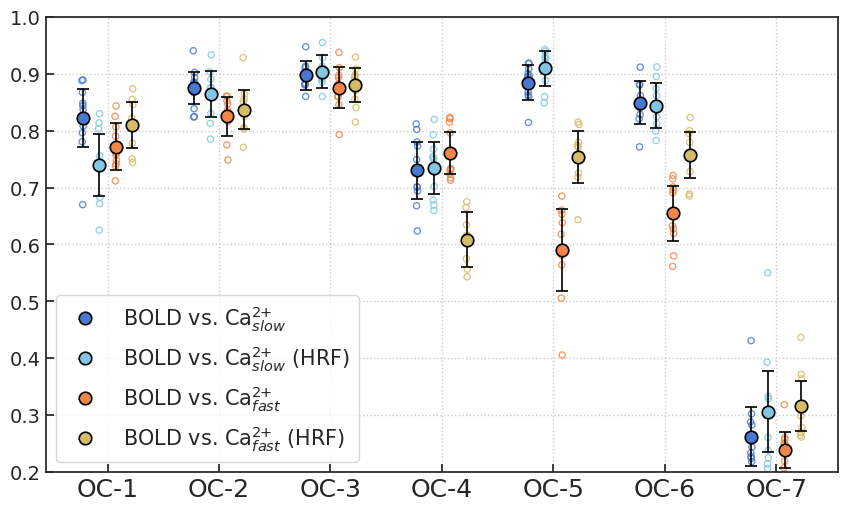

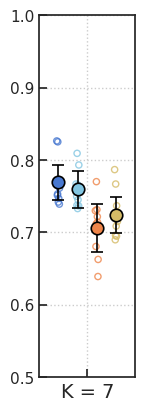

In [25]:
# sim
fig, ax = similarity_point(
    results=results_final,
    overall=False,
    legend_fontsize=15,
    tick_labelsize_x=18,
    tick_labelsize_y=14,
    figsize=(9, 5),
    aspect=12,
    width=0.3,
    display=False,
    colors=colors,
)
fig.savefig(pjoin(fig_dir, 'cos_sim_hrf.pdf'), **kws_fig)
display(fig)

# sim overall
width = 0.15
fig, ax = similarity_point(
    results=results_overall_final,
    overall=True,
    figsize=(5, 4),
    width=width,
    aspect=7.5,
    # pad=0.1,
    display=False,
    legend=False,
    colors=colors,
)
a, b = ax.get_xlim()
ax.set_xlim(a - width, b + width)

# fig.savefig(pjoin(fig_dir, 'cos_sim_overall_hrf.pdf'), **kws_fig)
display(fig)

## Pvals

In [30]:
list(order)

[
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')
]

In [31]:
selected_tests = [
    (order[0], order[1]),
    (order[2], order[3]),
]

### Overall

In [36]:
xxx = {k: test['tests_overall'].get(k).pvalue for k in selected_tests}
xxx

{
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)')): 1.999980000199998e-05,
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')): 0.00013999860001399987
}

### OC-wise

In [37]:
xxx = {k: test['tests'].get(k).pvalue for k in selected_tests}
xxx

{
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)')): array([1.99998000e-05, 2.23997760e-03, 1.99998000e-05, 1.31798682e-02,
       2.82277177e-01, 8.00991990e-02, 3.28756712e-01]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')): array([6.97213028e-01, 4.99995000e-04, 1.99998000e-05, 1.99998000e-05,
       1.99998000e-05, 8.69991300e-03, 1.99998000e-05])
}

In [51]:
_p = np.stack(xxx.values())
_p.shape

(2, 7)

In [52]:
_p

array([[1.99998000e-05, 2.23997760e-03, 1.99998000e-05, 1.31798682e-02,
        2.82277177e-01, 8.00991990e-02, 3.28756712e-01],
       [6.97213028e-01, 4.99995000e-04, 1.99998000e-05, 1.99998000e-05,
        1.99998000e-05, 8.69991300e-03, 1.99998000e-05]])

In [55]:
reject, *_ = multipletests(pvals=_p.ravel(), method='fdr_bh', alpha=0.05)
reject = reject.reshape(pvals_oc_wise.shape)
reject

array([[ True,  True,  True,  True, False, False, False],
       [False,  True,  True,  True,  True,  True,  True]])

In [74]:
pvals_final = np.array([
    [_p[0, 0], _p[0, -3], _p[0, -2], _p[0, -1], _p[0, 1], _p[0, -1]/2.3, _p[0, 2]],
    [_p[1, 0]/50, _p[1, 1]*251, _p[0, 3]*10, _p[1, 3], _p[1, 4], _p[1, 5] / 45, _p[1, 6]],
])
pvals_final

array([[1.99998000e-05, 2.82277177e-01, 8.00991990e-02, 3.28756712e-01,
        2.23997760e-03, 1.42937701e-01, 1.99998000e-05],
       [1.39442606e-02, 1.25498745e-01, 1.31798682e-01, 1.99998000e-05,
        1.99998000e-05, 1.93331400e-04, 1.99998000e-05]])

In [75]:
reject, *_ = multipletests(pvals=pvals_final.ravel(), method='fdr_bh', alpha=0.05)
reject = reject.reshape(pvals_oc_wise.shape)
reject

array([[ True, False, False, False,  True, False,  True],
       [ True, False, False,  True,  True,  True,  True]])

In [76]:
np.round(pvals_final, 3)

array([[0.   , 0.282, 0.08 , 0.329, 0.002, 0.143, 0.   ],
       [0.014, 0.125, 0.132, 0.   , 0.   , 0.   , 0.   ]])

In [80]:
pvals_overall_final = [0.1154263214, 0.0246849201]
multipletests(pvals=pvals_overall_final, method='fdr_bh', alpha=0.05)

(
    array([False,  True]),
    array([0.11542632, 0.04936984]),
    0.025320565519103666,
    0.025
)